Buy - Sale - Hold: Predicting S&P500 closing price.

This is a part 1 of a series of experiments where I attempt to forecast the S&P 500 closing price. The exercise aims to measure tendencies in the S&P to help us
adjust positions and balance our portfolio. We'll inspect the data as usual running a few tests, and for simplicity I'll use the ARIMA (Autoregressive Moving Average) model.

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import scipy as sp

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.tools as tls

# Imports in order to be able to use Plotly offline.

from plotly.offline import init_notebook_mode,plot, iplot
init_notebook_mode(connected=True)
import plotly.offline as pyo
pyo.init_notebook_mode()

import dash
import dash_core_components as dcc
import dash_html_components as html
import warnings
import itertools

import seaborn as sns

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

from pandas_datareader import data as pdr

In [2]:
# Download historical S&P daily information

df = pdr.get_data_yahoo("^GSPC", start="2001-01-01", end="2019-03-27")

In [3]:
# Review frame of dataset. By default, pandas sets 'Date' as index and assigns date-time format

df.head()

High          Low         Open        Close      Volume  \
Date                                                                         
2001-01-02  1320.280029  1276.050049  1320.280029  1283.270020  1129400000   
2001-01-03  1347.760010  1274.619995  1283.270020  1347.560059  1880700000   
2001-01-04  1350.239990  1329.140015  1347.560059  1333.339966  2131000000   
2001-01-05  1334.770020  1294.949951  1333.339966  1298.349976  1430800000   
2001-01-08  1298.349976  1276.290039  1298.349976  1295.859985  1115500000   

              Adj Close  
Date                     
2001-01-02  1283.270020  
2001-01-03  1347.560059  
2001-01-04  1333.339966  
2001-01-05  1298.349976  
2001-01-08  1295.859985

In [4]:
# Check data types

df.dtypes

High         float64
Low          float64
Open         float64
Close        float64
Volume         int64
Adj Close    float64
dtype: object

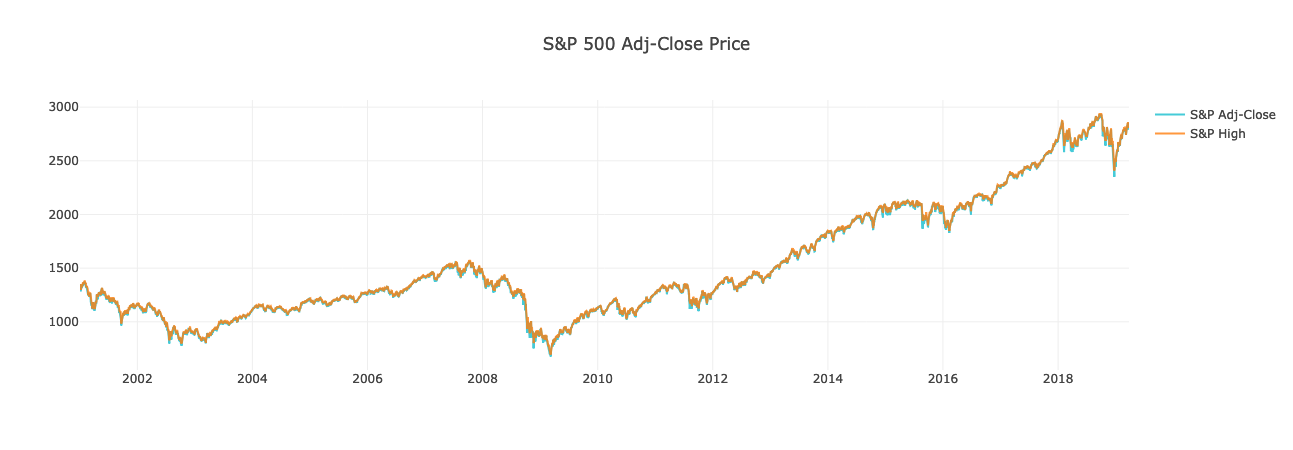

In [5]:
trace_close = go.Scatter(
                x=df.index,
                y=df['Adj Close'],
                name = "S&P Adj-Close",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

trace_high = go.Scatter(
                x=df.index,
                y=df['High'],
                name = "S&P High",
                opacity = 0.8)

data = [trace_close,trace_high]

layout = dict(
    title = "S&P 500 Adj-Close Price"
)

fig = dict(data=data, layout=layout)
pyo.iplot(fig)

In [7]:
# Normalize average closing price of S&P's 'Adjusted Close' to monthly average. 

# Adjusted close is used as prediction variable because it has been amended to include distributions and/or corporate actions that occurred before the next day.

y = df['Adj Close'].resample('MS').mean()

In [8]:
y[:'2019']

Date
2001-01-01    1335.639056
2001-02-01    1305.751580
2001-03-01    1185.850009
2001-04-01    1189.837000
2001-05-01    1270.368636
2001-06-01    1238.710467
2001-07-01    1204.449521
2001-08-01    1178.503927
2001-09-01    1044.643994
2001-10-01    1076.590438
2001-11-01    1129.683332
2001-12-01    1144.930011
2002-01-01    1140.207624
2002-02-01    1100.668939
2002-03-01    1153.791003
2002-04-01    1112.034540
2002-05-01    1079.267278
2002-06-01    1014.048007
2002-07-01     903.585458
2002-08-01     912.552274
2002-09-01     867.812006
2002-10-01     854.631308
2002-11-01     909.927005
2002-12-01     899.178574
2003-01-01     895.836190
2003-02-01     837.618951
2003-03-01     846.621425
2003-04-01     890.025713
2003-05-01     935.962853
2003-06-01     987.995239
                 ...     
2016-10-01    2143.020938
2016-11-01    2164.985689
2016-12-01    2246.629046
2017-01-01    2275.115979
2017-02-01    2329.910542
2017-03-01    2366.822170
2017-04-01    2359.309455
2017-05

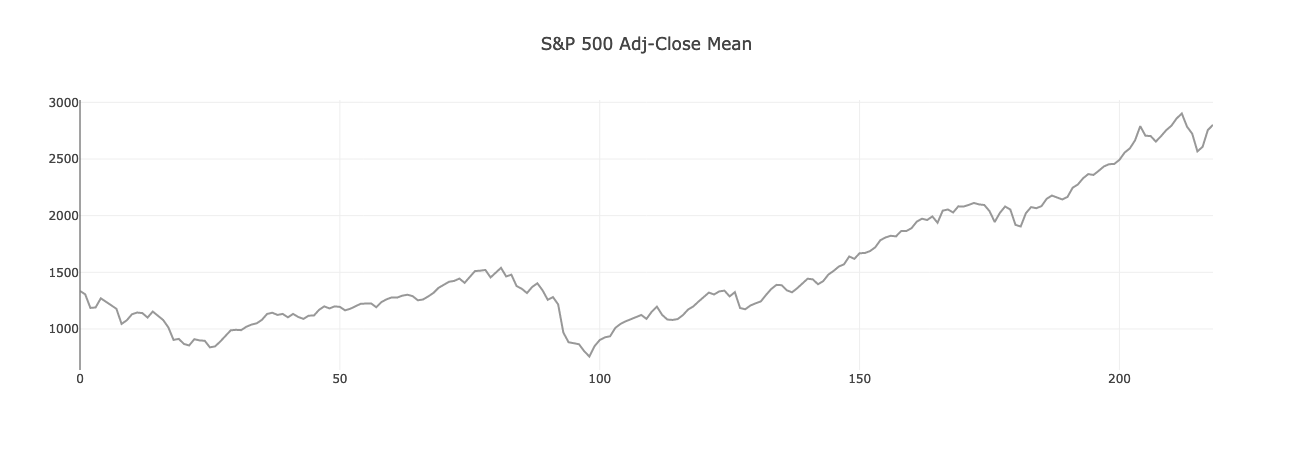

In [9]:
trace0= go.Scatter(
    y=df['Adj Close'].resample('MS').mean(),
    name = "S&P Mean",
    line = dict(color = '#7F7F7F'),
    opacity = 0.8)

data = [trace0]

layout = dict(
    title = "S&P 500 Adj-Close Mean"
)

fig = dict(data=data, layout=layout)
pyo.iplot(fig)

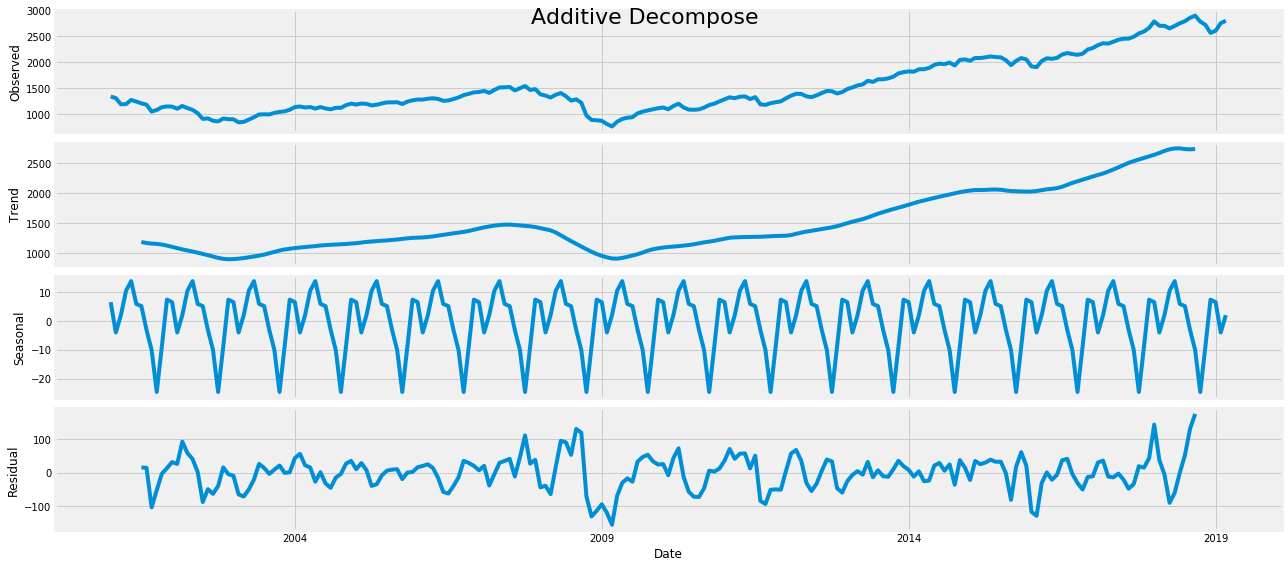

In [10]:
# Download library and set up the ARIMA model considering the series as additive and multiplicative combiantion.

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

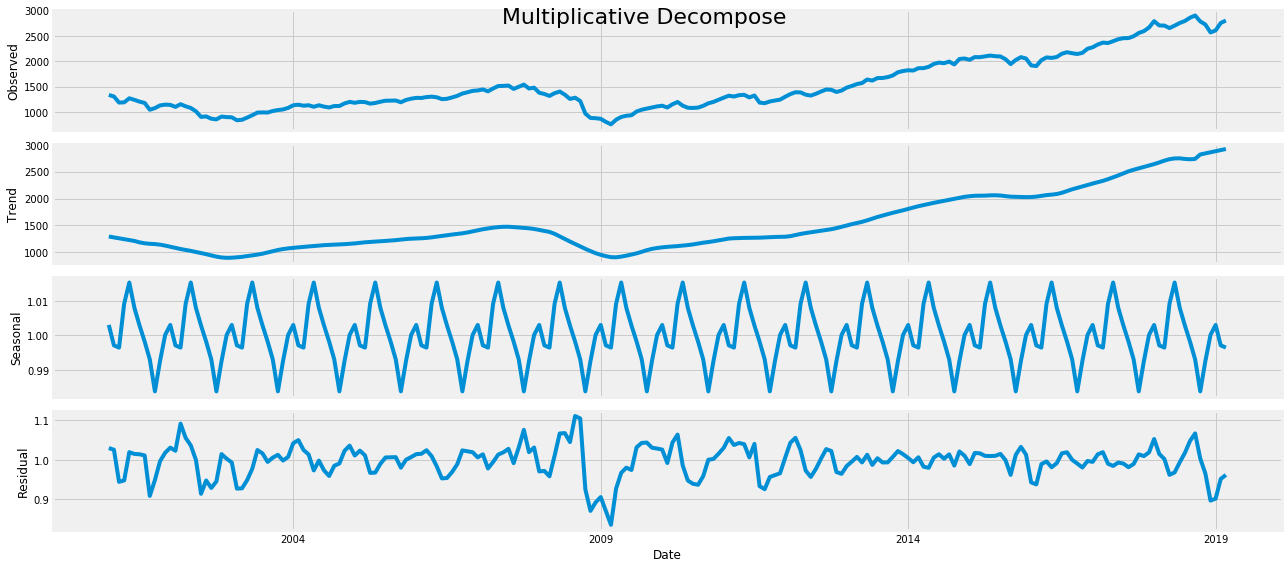

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', extrapolate_trend='freq')
fig = decomposition.plot().suptitle('Multiplicative Decompose', fontsize=22)
plt.show()

At first hand both results look close, both cases showing strong seasonality but with the multiplicative decomposition slightly more ramdom, which is what we're looking for.

We will now test for stationarity using the Augmented Dickey Fuller and KPSS test in order to ensure that values are not a function of time thus guarantying forecasting reliability.

In [12]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df['Adj Close'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df['Adj Close'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.7547392149352001
p-value: 0.9908693061793347
Critial Values:
   1%, -3.431782350810031
Critial Values:
   5%, -2.8621729309985806
Critial Values:
   10%, -2.5671069122000763

KPSS Statistic: 10.403960
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


Based on the results of both tests, we can see that the model is not stationary; thus to address the inconvenience we'll make our series stationary as follows:

In [13]:
from collections import namedtuple # To iterate through sections of the series

ADF = namedtuple("ADF", 'adf pvalue usedlag nobs critical icbest')

In [14]:
ADF(*smt.adfuller(y))._asdict()

OrderedDict([('adf', 0.1963857021197847),
             ('pvalue', 0.9720581488617439),
             ('usedlag', 8),
             ('nobs', 210),
             ('critical',
              {'1%': -3.461878735881654,
               '5%': -2.875403665910809,
               '10%': -2.574159410430839}),
             ('icbest', 2157.5515405893375)])

In [15]:
ADF(*smt.adfuller(y.diff().dropna()))._asdict()

OrderedDict([('adf', -4.265730628516271),
             ('pvalue', 0.000508988310005582),
             ('usedlag', 7),
             ('nobs', 210),
             ('critical',
              {'1%': -3.461878735881654,
               '5%': -2.875403665910809,
               '10%': -2.574159410430839}),
             ('icbest', 2146.030613316773)])

Since the ADF < 'Critical 1%' the model is now stationary

In [16]:
def tsplot(y, lags=None, figsize=(18, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [17]:
data = (y.to_frame(name='y')
         .assign(Δy=lambda df: df.y.diff())
         .assign(LΔy=lambda df: df.Δy.shift()))
mod_stationary = smf.ols('Δy ~ LΔy', data=data.dropna())
res_stationary = mod_stationary.fit()

(<matplotlib.axes._subplots.AxesSubplot at 0x112310b70>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11236b470>)

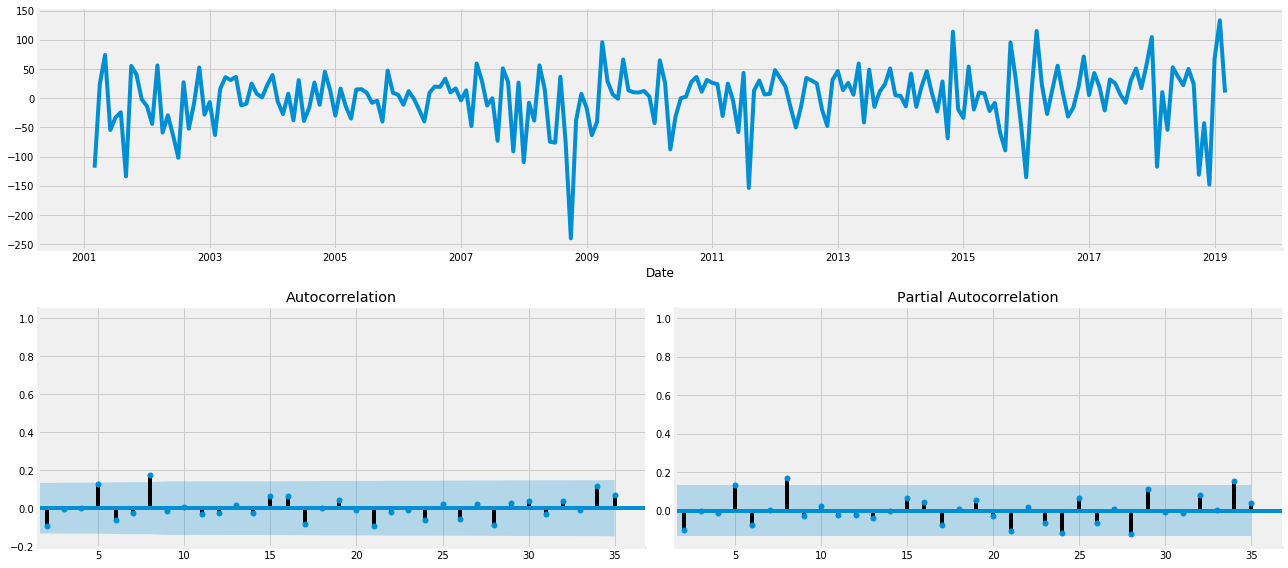

In [18]:
tsplot(res_stationary.resid, lags=35)

With a general inspection in the series and after identifying and addressing standard problems in time series (autocorrelation, multicollinearity, seasonality, etc.), let's set-up ARIMA to help us with the inconveniences.

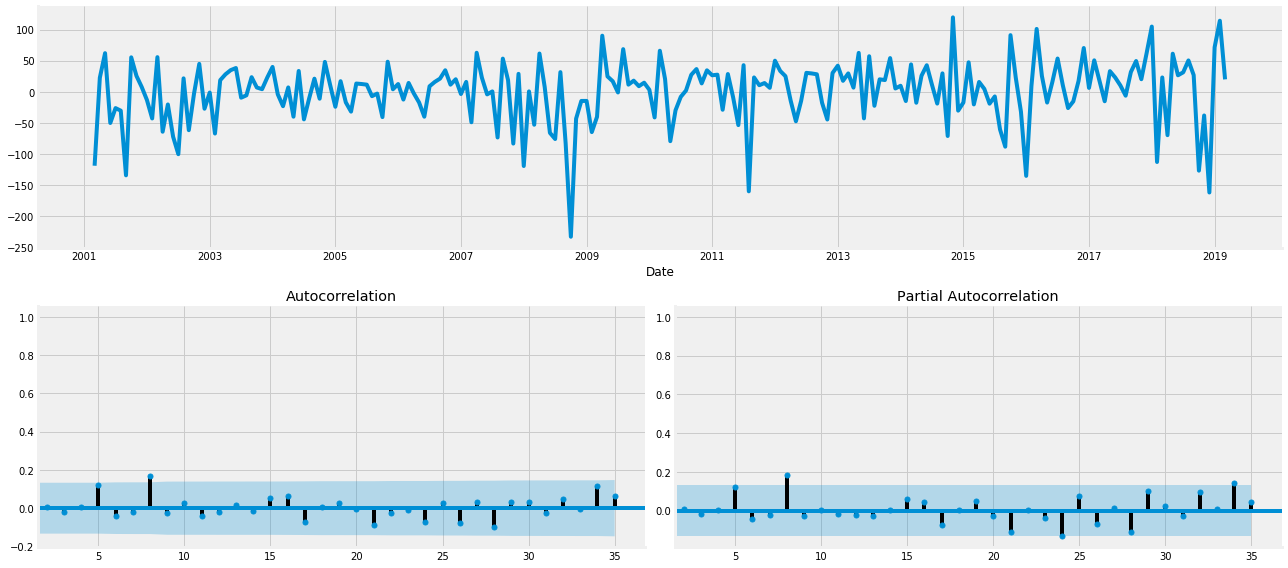

In [19]:
mod = smt.SARIMAX(y, trend='c', order=(1, 1, 1))
res = mod.fit()
tsplot(res.resid[2:], lags=35);

In [20]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  219
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1159.102
Date:                Wed, 03 Apr 2019   AIC                           2326.205
Time:                        09:57:27   BIC                           2339.743
Sample:                    01-01-2001   HQIC                          2331.673
                         - 03-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.4559      5.750      1.471      0.141      -2.813      19.725
ar.L1         -0.2558      0.241     -1.063      0.288      -0.728       0.216
ma.L1          0.4930      0.209      2.359      0.018       0.083       0.903
sigma2      2430.3763    179.848     13.514      0.000    2077.881    2782.872
===================================================================================
Ljung-Box (Q):                       31.67   Jarque-Bera (JB):               110.30
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 8) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 8)
SARIMAX: (0, 0, 1) x (0, 1, 0, 8)
SARIMAX: (0, 1, 0) x (0, 1, 1, 8)
SARIMAX: (0, 1, 0) x (1, 0, 0, 8)


In [22]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}8 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 8)8 - AIC:3859.6725702356994
ARIMA(0, 0, 0)x(0, 0, 1, 8)8 - AIC:3610.757566943276
ARIMA(0, 0, 0)x(0, 1, 0, 8)8 - AIC:2787.3599848198187
ARIMA(0, 0, 0)x(0, 1, 1, 8)8 - AIC:2776.328989229606
ARIMA(0, 0, 0)x(1, 1, 0, 8)8 - AIC:2774.286293758007
ARIMA(0, 0, 0)x(1, 1, 1, 8)8 - AIC:2776.254049422327
ARIMA(0, 0, 1)x(0, 0, 0, 8)8 - AIC:3568.4499465781464
ARIMA(0, 0, 1)x(0, 0, 1, 8)8 - AIC:3323.0132624547105
ARIMA(0, 0, 1)x(0, 1, 0, 8)8 - AIC:2556.296138323179
ARIMA(0, 0, 1)x(0, 1, 1, 8)8 - AIC:2551.267669535224
ARIMA(0, 0, 1)x(1, 1, 0, 8)8 - AIC:2549.98290294671
ARIMA(0, 0, 1)x(1, 1, 1, 8)8 - AIC:2555.501768381634
ARIMA(0, 1, 0)x(0, 0, 0, 8)8 - AIC:2336.7815774442456
ARIMA(0, 1, 0)x(0, 0, 1, 8)8 - AIC:2331.7728018921853
ARIMA(0, 1, 0)x(0, 1, 0, 8)8 - AIC:2335.5334606023935
ARIMA(0, 1, 0)x(0, 1, 1, 8)8 - AIC:2261.401603248449
ARIMA(0, 1, 0)x(1, 0, 0, 8)8 - AIC:2330.338450113091
ARIMA(0, 1, 0)x(1, 0, 1, 8)8 - AIC:2331.7208572113213
ARIMA(0, 1, 0)x(1, 1, 0, 8)8 - AIC:2295

In [23]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 0),
                                seasonal_order=(1, 1, 0, 8),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9581      0.019     51.568      0.000       0.922       0.994
ar.S.L8       -0.4393      0.054     -8.129      0.000      -0.545      -0.333
sigma2      3130.1111    227.628     13.751      0.000    2683.968    3576.254


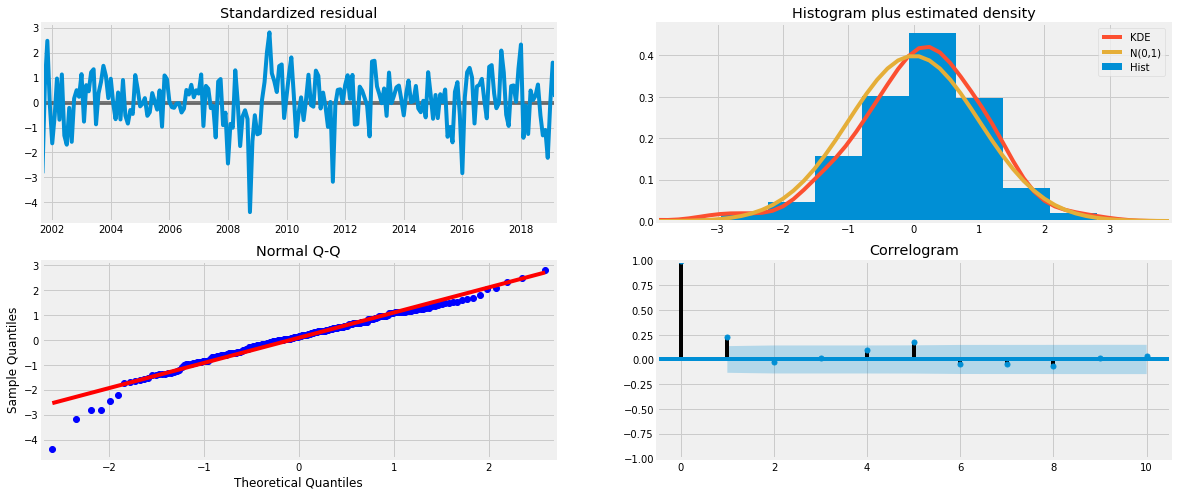

In [24]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

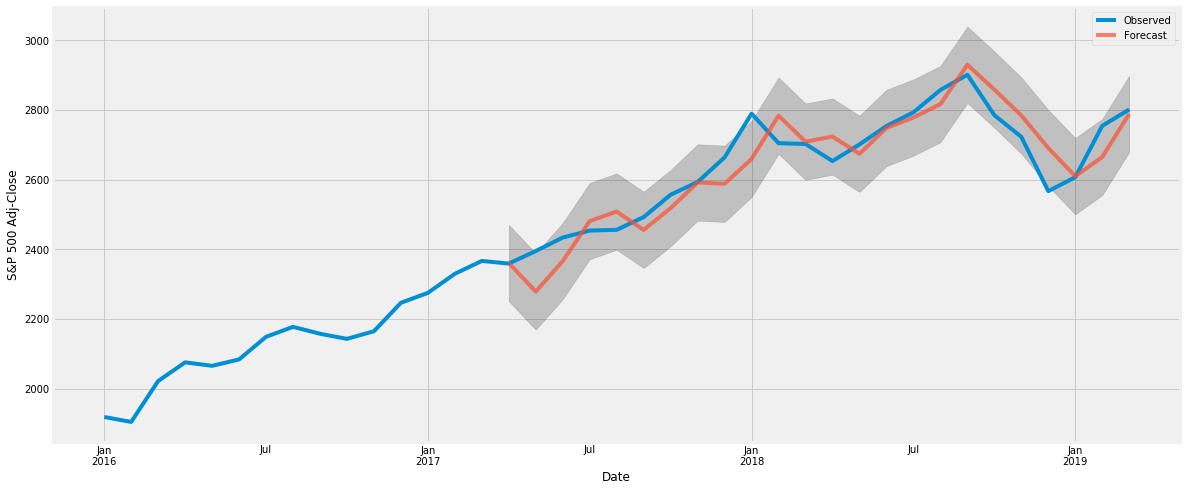

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2016':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(18, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('S&P 500 Adj-Close')
plt.legend()
plt.show()

Results are not too bad, and gives us a general idea of when to buy - sell - hold. Nevertheless, the series seems unstable on and before June 2018.

In [26]:
pred_dy = results.get_prediction(start='2018-01-01', dynamic='2019-03-01')
pred_dy_ci = pred_dy.conf_int()

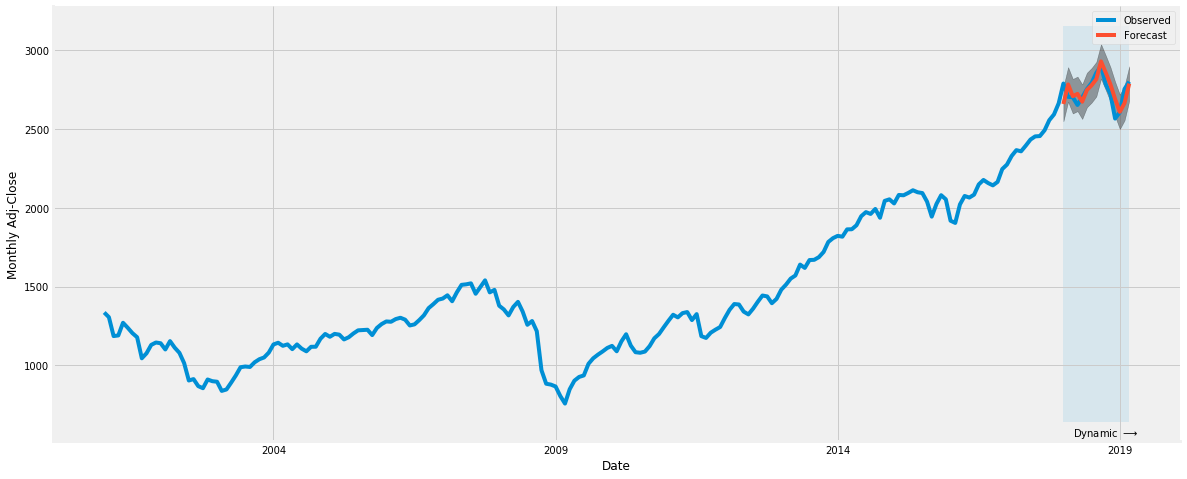

In [27]:
ax = y.plot(label='Observed')
pred_dy.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_dy_ci.index,
                pred_dy_ci.iloc[:, 0],
                pred_dy_ci.iloc[:, 1], color='k', alpha=.35)
ax.set_ylabel("Monthly Adj-Close")

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp('2018-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)
ax.annotate('Dynamic $\\longrightarrow$', (pd.Timestamp('2018-03-01'), 550))

plt.legend()
sns.despine()

In [28]:
y_forecasted = pred.predicted_mean
y_actual = y['2018-01-01':]
mse = ((y_forecasted - y_actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 5)))

The Mean Squared Error of our forecasts is 4287.35847


In [29]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 5)))

The Root Mean Squared Error of our forecasts is 65.47792


pred_uc = results.get_forecast(steps=3)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='S&P observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='S&P Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Adj Close')
plt.legend()
plt.show()

Results are encouraging as the RSME (Root Mean Squared Error) is +/- 65 points off target. As it stands we are certain that the S&P closing value will range between (2670 and 2932) in the next month or so. Nevertheless, there's room for improvement in the model and we'll visit other measures on following examples.